In [1]:
#Gracias a Gustavo Candela por toda la asesoría
bnbIdAuthor = 'http://bnb.data.bl.uk/id/person/WoolfVirginia1882-1941

In [2]:
import folium #instrucciones para cargar: https://anaconda.org/conda-forge/folium (los demás están en anaconda)
import requests
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  

In [3]:
url = 'https://bnb.data.bl.uk/sparql'

query = """
PREFIX blt: <http://www.bl.uk/schemas/bibliographic/blterms#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX c4dm: <http://purl.org/NET/c4dm/event.owl#>

SELECT DISTINCT ?resource ?title ?date ?place WHERE {{
   graph <http://bnb.data.bl.uk/id/graph/BNBCIP> {{
      ?resource ?p <{0}> ;
         dct:title ?title ;
         schema:datePublished ?date .
      OPTIONAL {{
          ?resource blt:projectedPublication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
      OPTIONAL {{
          ?resource blt:publication ?publication .
          ?publication c4dm:place ?place .
          FILTER regex(?place, "geonames", "i")        
      }}
   }}
}} LIMIT 500
"""

query = query.format(bnbIdAuthor) #aquí se pone el autor

# Usamos un json como salida
headers = {'Accept': 'application/sparql-results+json'}
r = requests.get(url, params = {'format': 'application/sparql-results+json', 'query': query}, headers=headers)
print('¡Ya tengo los elementos!')

¡Ya tengo los elementos!


In [5]:
r.text #revisando que sí se descargó el json con la información que requeríamos

'\n{ "head": { "link": [], "vars": ["resource", "title", "date", "place"] },\n  "results": { "distinct": false, "ordered": true, "bindings": [\n    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/013001764" }\t, "title": { "type": "literal", "value": "The years" }\t, "date": { "type": "literal", "value": "2004-12" }\t, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},\n    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/019599487" }\t, "title": { "type": "literal", "value": "Mrs Dalloway" }\t, "date": { "type": "literal", "value": "2020-01" }\t, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},\n    { "resource": { "type": "uri", "value": "http://bnb.data.bl.uk/id/resource/017816985" }\t, "title": { "type": "literal", "value": "Mrs Dalloway" }\t, "date": { "type": "literal", "value": "2016-05" }\t, "place": { "type": "uri", "value": "http://sws.geonames.org/6269131/" }},\n    { "resour

In [7]:
bnbdata = json.loads(r.text) #aquí cargamos nuestros datos a bnbdata

with open('bnb_records_virginia.csv', 'w', newline='') as file:
    csv_out = csv.writer(file, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)    
    csv_out.writerow(['resource', 'place', 'title', 'date'])

    for i in bnbdata['results']['bindings']:
        #print(i['place']['value'])
        resource = place = title = date =''
        resource = i['resource']['value']
        place = i['place']['value']
        title = i['title']['value']
        date = i['date']['value']

        csv_out.writerow([resource,place,title,date])

In [9]:
df = pd.read_csv('bnb_records_virginia.csv')

In [10]:
places_by_number = df.groupby("place")["resource"].count()

In [11]:
places_by_number

place
http://sws.geonames.org/6252001/     5
http://sws.geonames.org/6269131/    31
Name: resource, dtype: int64

In [12]:
places_by_number[['http://sws.geonames.org/6269131/']][0]

31

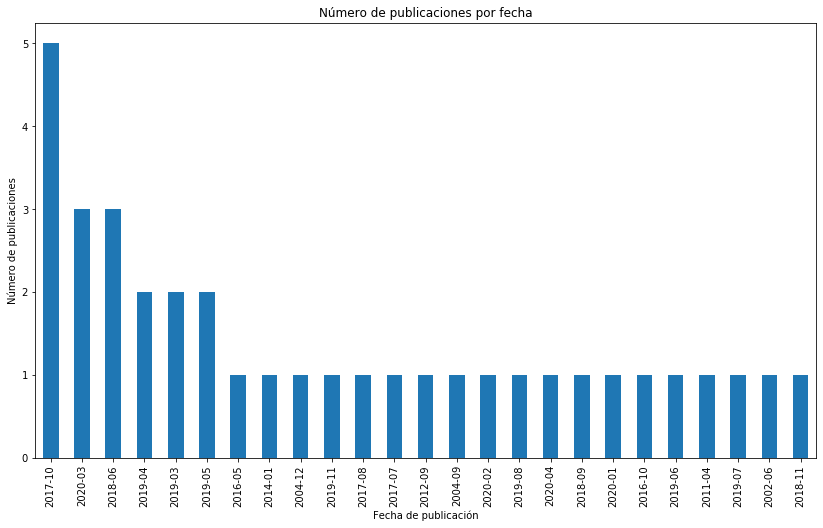

In [14]:
ax = df['date'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de publicaciones por fecha") #¿cómo se podría ordenar esta gráfica por fecha?
ax.set_xlabel("Fecha de publicación")
ax.set_ylabel("Número de publicaciones")
plt.show()

In [15]:
df['year'] = pd.DatetimeIndex(df['date']).year

In [16]:
df = df.sort_values('year')

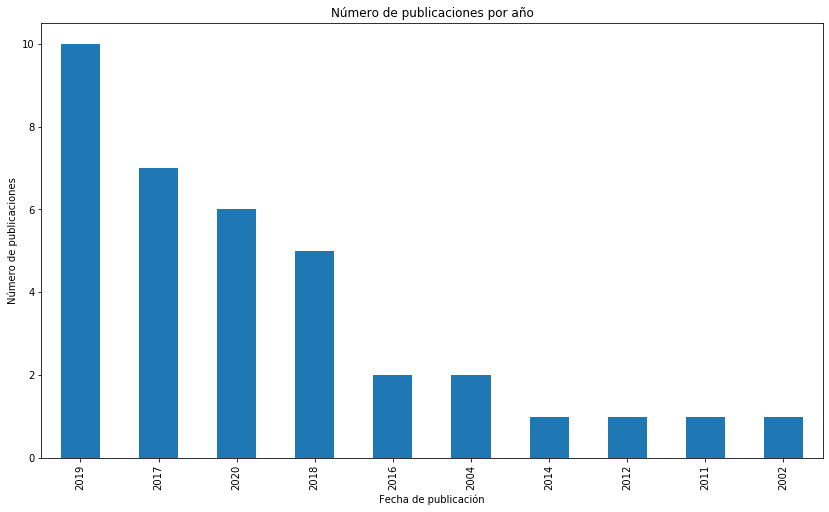

In [17]:
ax = df['year'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Número de publicaciones por año")
ax.set_xlabel("Fecha de publicación")
ax.set_ylabel("Número de publicaciones")
plt.show()

In [18]:
# Obtener los lugares de publicación diferentes
places = pd.unique(df['place']).tolist()
strplaces = ''
for a in sorted(places):
    print(a)
    strplaces = strplaces + ' \"' + a.replace("http://sws.geonames.org/", "").replace("/", "") + '\"'

http://sws.geonames.org/6252001/
http://sws.geonames.org/6269131/


In [19]:
strplaces #obtener la lista de los ids de lugar

' "6252001" "6269131"'

In [21]:
url = 'https://query.wikidata.org/sparql'
query = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
SELECT ?idgeonames ?lat ?lon ?x ?xLabel 
WHERE {{ 
  values ?idgeonames {{ {0} }} 
  ?x wdt:P1566 ?idgeonames ; 
   p:P625 [
     psv:P625 [
       wikibase:geoLatitude ?lat ;
       wikibase:geoLongitude ?lon ;
       wikibase:geoGlobe ?globe ;
     ];
     ps:P625 ?coord
   ]
   SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
}}
"""

query = query.format(strplaces) #aquí se metieron los ids únicos de geonames que en el paso anterior
#print(query) #quitar comentario para ver la consulta (query)

r = requests.get(url, params = {'format': 'json', 'query': query})
geopoints = r.json()

In [22]:
map = folium.Map(location=[0,0], zoom_start=1.5)

for geo in geopoints['results']['bindings']:
    idwikidata = geo['x']['value']
    lat = geo['lat']['value']
    lon = geo['lon']['value']
    idgeonames = geo['idgeonames']['value']
    label = geo['xLabel']['value']
    print(lat, lon)
    
    # adding a text to the popup
    count = places_by_number[['http://sws.geonames.org/' + idgeonames + '/']][0]
    popup = str(count) + " records published in <a hreh='" + str(idwikidata) + "'>" + label + "</a>"
    
    folium.Marker([lat,lon], popup= popup).add_to(map)

53.0 -1.0
39.828175 -98.5795


In [23]:
map